# **Group 11 - Modelling - Big Data and Cloud Computing (ADSP 31013)**

## Members:
- #### **Andrew Rafael James** 
- #### **Aravind Shreyas Ramesh** 
- #### **Reethesh Venkatraman** 
- #### **Rohit Kumar** 
- #### **Sahil Bharwani**

---

### **Flight Delay Prediction:**
*This project aims to identify drivers of delay of departures and arrival flights considering various factors including but not limited to origin, destination, distance, weather, taxi time, time, seasonality etc. and quantify the effect of these drivers.*

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, radians, sin, cos, sqrt, atan2, lit, round, to_date, to_timestamp, date_format
from pyspark.sql import Window
import pandas as pd
import numpy as np
from pyspark.sql.types import DoubleType
import math
from pyspark.sql import Window
from pyspark.sql.functions import col, when, avg, count, month, dayofmonth, year, desc, rank, when, sum
from pyspark.sql.functions import col, corr, desc
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import hour, minute, floor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import logging
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StandardScaler
from sklearn.ensemble import RandomForestClassifier as SklearnRF
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import RandomForestClassificationModel,GBTClassificationModel,DecisionTreeClassificationModel,LogisticRegressionModel
from pyspark.sql.functions import udf, col, when
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import DoubleType

# import geohash
# import pygeohash as pgh

# from geopy.distance import geodesic
# from scipy.spatial import KDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#create Spark session
spark = SparkSession.builder.appName('EDA').config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()


#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '16g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '8'), ('spark.cores.max', '8'), ('spark.driver.memory','16g')])

#set log level
spark.sparkContext.setLogLevel("ERROR")

In [3]:
logger = logging.getLogger("py4j")
logger.setLevel(logging.ERROR)

log4jLogger = spark._jvm.org.apache.log4j
log4jLogger.LogManager.getLogger("org.apache.spark.scheduler.DAGScheduler").setLevel(log4jLogger.Level.ERROR)

In [4]:
# GCS path to the Parquet file
gcs_path = "gs://msca-bdp-student-gcs/Group11/flight_weather_joined_2018_2021_v2.parquet"

# Read the Parquet file into a DataFrame
df = spark.read.parquet(gcs_path)

# Show the first few rows of the DataFrame
df.count()

25115464

In [5]:
print(df.columns)

['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups'

# **Feature Engineering**

In [6]:
df_model = df
df_model.select("Airline").distinct().count() #28


28

In [7]:
df_model.select("Marketing_Airline_Network").distinct().show(2) #11

+-------------------------+
|Marketing_Airline_Network|
+-------------------------+
|                       UA|
|                       NK|
+-------------------------+
only showing top 2 rows



In [8]:
df_model.select("Operated_or_Branded_Code_Share_Partners").distinct().show(2) #16

+---------------------------------------+
|Operated_or_Branded_Code_Share_Partners|
+---------------------------------------+
|                                     UA|
|                                     NK|
+---------------------------------------+
only showing top 2 rows



In [9]:
df_model.select("Airline", "Operating_Airline").distinct().show(2) #28 # 1 to 1 mapping

+-----------------+-----------------+
|          Airline|Operating_Airline|
+-----------------+-----------------+
|      Comair Inc.|               OH|
|Republic Airlines|               YX|
+-----------------+-----------------+
only showing top 2 rows



In [10]:
selected_features = [
    'Airline', 'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime', 'Distance', 
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
    'Marketing_Airline_Network', 
    'PRCP_origin', 'airport_latitude_origin', 'airport_longitude_origin',  
    'PRCP_dest', 'airport_latitude_dest', 'airport_longitude_dest']
target = 'DepDel15'

df_model.select(selected_features + [target]).show(2)

+--------------------+----------+--------------+----------+--------+----+-------+-----+----------+---------+-------------------------+-----------+-----------------------+------------------------+---------+---------------------+----------------------+--------+
|             Airline|CRSDepTime|CRSElapsedTime|CRSArrTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|PRCP_origin|airport_latitude_origin|airport_longitude_origin|PRCP_dest|airport_latitude_dest|airport_longitude_dest|DepDel15|
+--------------------+----------+--------------+----------+--------+----+-------+-----+----------+---------+-------------------------+-----------+-----------------------+------------------------+---------+---------------------+----------------------+--------+
|ExpressJet Airlin...|      1515|         124.0|      1719|   692.0|2018|      1|    1|         7|        7|                       DL|          0|                33.6367|              -84.428101|        0|            40.

In [11]:
%%time
columns_to_check = selected_features + [target]

fill_rate_exprs = [
    (F.count(F.when(F.col(col).isNotNull(), 1)) / F.count("*")).alias(f"{col}_fill_rate") 
    for col in columns_to_check
]

fill_rate_df = df_model.select(*fill_rate_exprs)

fill_rate_df.toPandas().stack()

CPU times: user 61.3 ms, sys: 16.4 ms, total: 77.7 ms
Wall time: 6.35 s


0  Airline_fill_rate                      1.000000
   CRSDepTime_fill_rate                   1.000000
   CRSElapsedTime_fill_rate               0.999999
   CRSArrTime_fill_rate                   1.000000
   Distance_fill_rate                     1.000000
   Year_fill_rate                         1.000000
   Quarter_fill_rate                      1.000000
   Month_fill_rate                        1.000000
   DayofMonth_fill_rate                   1.000000
   DayOfWeek_fill_rate                    1.000000
   Marketing_Airline_Network_fill_rate    1.000000
   PRCP_origin_fill_rate                  0.989426
   airport_latitude_origin_fill_rate      0.993593
   airport_longitude_origin_fill_rate     0.993593
   PRCP_dest_fill_rate                    0.989422
   airport_latitude_dest_fill_rate        0.993592
   airport_longitude_dest_fill_rate       0.993592
   DepDel15_fill_rate                     0.974415
dtype: float64

In [12]:
df_model_non_null = df_model.select(selected_features + [target]).na.drop()

fill_rate_df = df_model_non_null.select(*fill_rate_exprs)
fill_rate_df.toPandas().stack()

0  Airline_fill_rate                      1.0
   CRSDepTime_fill_rate                   1.0
   CRSElapsedTime_fill_rate               1.0
   CRSArrTime_fill_rate                   1.0
   Distance_fill_rate                     1.0
   Year_fill_rate                         1.0
   Quarter_fill_rate                      1.0
   Month_fill_rate                        1.0
   DayofMonth_fill_rate                   1.0
   DayOfWeek_fill_rate                    1.0
   Marketing_Airline_Network_fill_rate    1.0
   PRCP_origin_fill_rate                  1.0
   airport_latitude_origin_fill_rate      1.0
   airport_longitude_origin_fill_rate     1.0
   PRCP_dest_fill_rate                    1.0
   airport_latitude_dest_fill_rate        1.0
   airport_longitude_dest_fill_rate       1.0
   DepDel15_fill_rate                     1.0
dtype: float64

## *Encoding Columns that have String Values*

In [13]:
categorical_columns = ["Airline", "Marketing_Airline_Network"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_Index", handleInvalid="keep")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_Index", outputCol=f"{col}_OHE") 
    for col in categorical_columns
]

pipeline = Pipeline(stages=indexers + encoders)

pipeline_model = pipeline.fit(df_model_non_null)
df_encoded = pipeline_model.transform(df_model_non_null)

df_encoded.select("Airline", "Airline_Index", "Airline_OHE", "Marketing_Airline_Network", 
                  "Marketing_Airline_Network_Index", "Marketing_Airline_Network_OHE").show(2)

+--------------------+-------------+---------------+-------------------------+-------------------------------+-----------------------------+
|             Airline|Airline_Index|    Airline_OHE|Marketing_Airline_Network|Marketing_Airline_Network_Index|Marketing_Airline_Network_OHE|
+--------------------+-------------+---------------+-------------------------+-------------------------------+-----------------------------+
|ExpressJet Airlin...|         16.0|(27,[16],[1.0])|                       DL|                            2.0|               (11,[2],[1.0])|
|Delta Air Lines Inc.|          1.0| (27,[1],[1.0])|                       DL|                            2.0|               (11,[2],[1.0])|
+--------------------+-------------+---------------+-------------------------+-------------------------------+-----------------------------+
only showing top 2 rows



In [14]:
print(df_encoded.columns)
df_encoded = df_encoded.withColumn("CRSDepHour", floor(col("CRSDepTime") / 100))
df_encoded = df_encoded.withColumn("CRSArrHour", floor(col("CRSArrTime") / 100))

df_encoded.select('CRSDepHour', 'CRSDepTime', 'CRSArrHour', 'CRSArrTime').show(5)

['Airline', 'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'PRCP_origin', 'airport_latitude_origin', 'airport_longitude_origin', 'PRCP_dest', 'airport_latitude_dest', 'airport_longitude_dest', 'DepDel15', 'Airline_Index', 'Marketing_Airline_Network_Index', 'Airline_OHE', 'Marketing_Airline_Network_OHE']
+----------+----------+----------+----------+
|CRSDepHour|CRSDepTime|CRSArrHour|CRSArrTime|
+----------+----------+----------+----------+
|        15|      1515|        17|      1719|
|        21|      2130|        23|      2337|
|        13|      1345|        16|      1643|
|        15|      1525|        17|      1705|
|        20|      2026|        22|      2212|
+----------+----------+----------+----------+
only showing top 5 rows



# **1. Classification Models - To predict delay in departure**

### **1.1 Random Forest**

In [15]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_RF_model_rohit_v2"
rf_model = RandomForestClassificationModel.load(model_path)

In [16]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network', 'CRSDepTime', 'CRSArrTime']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol=target, 
    numTrees=100, 
    maxDepth=7, 
#     maxBins=32,
#     minInstancesPerNode=5, 
#     minInfoGain=0.01, 
#     featureSubsetStrategy="sqrt", 
    seed=42
)

#"Un-comment" the below line when you need to retrain the model

# rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Accuracy: 0.8349
Precision: 0.6971
Recall: 0.8349
F1 Score: 0.7598
CPU times: user 102 ms, sys: 21.8 ms, total: 123 ms
Wall time: 2min 29s


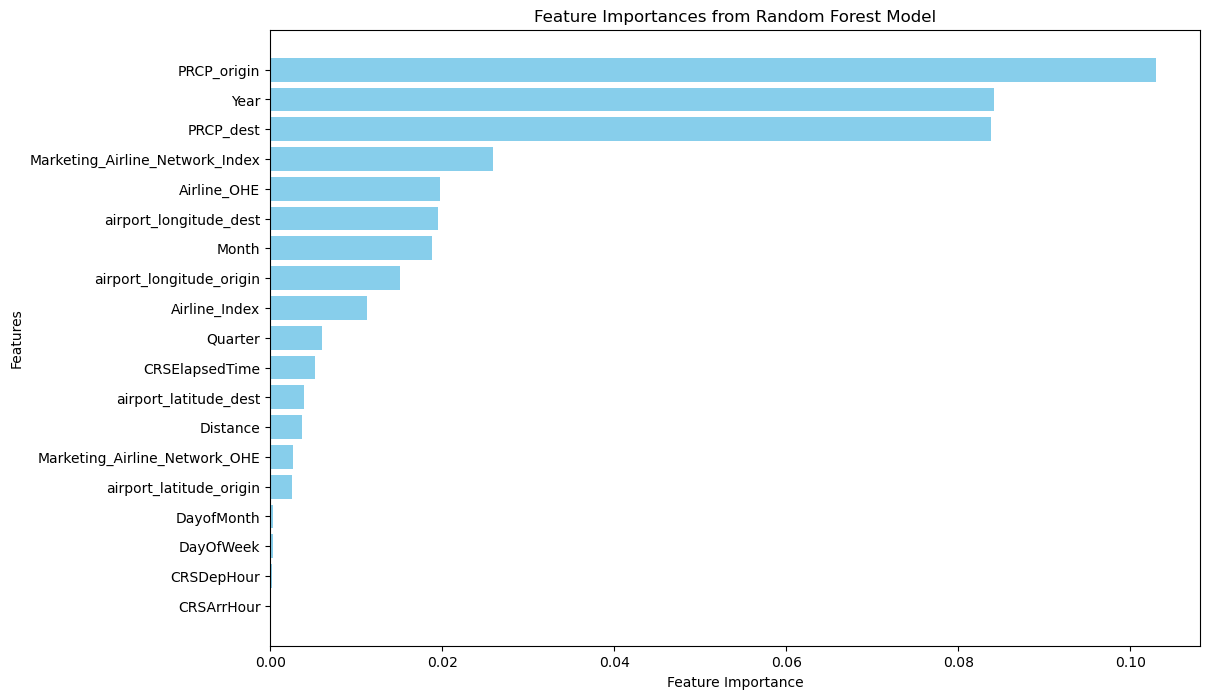

In [17]:
feature_importances = rf_model.featureImportances.toArray()

feature_importance_dict = {name: importance for name, importance in zip(features, feature_importances)}

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

features_1, importances = zip(*sorted_features)


plt.figure(figsize=(12, 8))
plt.barh(features_1, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [18]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_RF_model_rohit_v2"
#"Un-Comment" when you want to update model
#rf_model.write().overwrite().save(model_path)

### **1.2 Random Forest with Cross-Validation (takes very long)**

In [19]:
# %%time

# # Select the features and target
# features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

# # Step 1: Combine features into a single vector
# assembler = VectorAssembler(inputCols=features, outputCol="features")
# df_prepared = assembler.transform(df_encoded)

# # Step 2: Split data into training and testing datasets
# train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

# # Step 3: Initialize Random Forest Classifier
# rf = RandomForestClassifier(featuresCol="features", labelCol=target, seed=42)

# # Step 4: Set up the parameter grid for hyperparameter tuning
# paramGrid = (ParamGridBuilder()
#              .addGrid(rf.numTrees, [50, 100])
#              .addGrid(rf.maxDepth, [5, 10, 20])
#              .build())

# # Step 5: Initialize CrossValidator
# evaluator = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")

# crossval = CrossValidator(estimator=rf,
#                           evaluator=evaluator,
#                           estimatorParamMaps=paramGrid,
#                           numFolds=5,  # 5-fold cross-validation
#                           parallelism=2)  # Use 2 cores for parallelism

# # Step 6: Train the model with cross-validation
# cv_model = crossval.fit(train_df)

# # Step 7: Make predictions on the test dataset
# predictions = cv_model.transform(test_df)

# # Step 8: Initialize the evaluator for various metrics
# evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
# evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
# evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
# evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

# # Step 9: Calculate and print the metrics
# accuracy = evaluator_accuracy.evaluate(predictions)
# precision = evaluator_precision.evaluate(predictions)
# recall = evaluator_recall.evaluate(predictions)
# f1_score = evaluator_f1.evaluate(predictions)

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1_score:.4f}")

# # Optional: Show some predictions
# predictions.select("DepDel15", "probability", "prediction").show(10)

### **1.3 Gradient Boosted Trees Model**

In [23]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_lgbm_model_rohit"
#model_path_v2 = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_gbt_model_asr"
gbt_model = GBTClassificationModel.load(model_path)

In [24]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

gbt = GBTClassifier(featuresCol="features", labelCol=target, maxIter=100)

#"Un-comment" to update model

#gbt_model = gbt.fit(train_df)

predictions = gbt_model.transform(test_df)

#Used MulticlassClassificationEvaluator to get weighted precision and recall as its not available in BinaryclassClassificationEvaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


Accuracy: 0.8387
Precision: 0.8030
Recall: 0.8387
F1 Score: 0.7811
CPU times: user 168 ms, sys: 35.6 ms, total: 203 ms
Wall time: 2min 17s


In [25]:
df_metrics = predictions.select("DepDel15", "prediction")

tp_condition = (col("DepDel15") == 1) & (col("prediction") == 1)  # True Positive
tn_condition = (col("DepDel15") == 0) & (col("prediction") == 0)  # True Negative
fp_condition = (col("DepDel15") == 0) & (col("prediction") == 1)  # False Positive
fn_condition = (col("DepDel15") == 1) & (col("prediction") == 0)  # False Negative

metrics = df_metrics.select(
    sum(when(tp_condition, 1).otherwise(0)).alias("TP"),
    sum(when(tn_condition, 1).otherwise(0)).alias("TN"),
    sum(when(fp_condition, 1).otherwise(0)).alias("FP"),
    sum(when(fn_condition, 1).otherwise(0)).alias("FN")
)

metrics.toPandas().stack()

0  TP      54311
   TN    3965475
   FP      36329
   FN     736838
dtype: int64

In [26]:
#model_path_v2 = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_gbt_model_asr"
#gbt_model.write().overwrite().save(model_path_v2)

model_path = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_lgbm_model_rohit"
# gbt_model.write().overwrite().save(model_path)

## **1.4 Logistic Regression**

In [27]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_LR_model_rohit"
lr_model = LogisticRegressionModel.load(model_path)

In [28]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

# scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
# scaler_model = scaler.fit(df_prepared)
# df_scaled = scaler_model.transform(df_prepared)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol=target, regParam=0.1, maxIter=50)

#"Un-comment" when you want to re-train your model

# lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

#Used MulticlassClassificationEvaluator to get weighted precision and recall as its not available in BinaryclassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8349
Precision: 0.6971
Recall: 0.8349
F1 Score: 0.7598
CPU times: user 135 ms, sys: 25.8 ms, total: 161 ms
Wall time: 1min 20s


In [30]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_LR_model_rohit"
# lr_model.write().overwrite().save(model_path)

## **1.5 Decision Tree**

In [31]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/DepDel15_DT_model_rohit"
dt_model = DecisionTreeClassificationModel.load(model_path)

In [32]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol=target,
    maxDepth=10,               
    maxBins=32,                
    minInstancesPerNode=5,     
    minInfoGain=0.01,          
    impurity="gini",           
    seed=42                    
)

predictions = dt_model.transform(test_df)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8349
Precision: 0.6971
Recall: 0.8349
F1 Score: 0.7598
CPU times: user 122 ms, sys: 31.9 ms, total: 154 ms
Wall time: 1min 19s


# **2. Classification Models - To predict delay in arrivals**

In [37]:
selected_features = [
    'Airline', 'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime', 'Distance', 
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
    'Marketing_Airline_Network', 
    'PRCP_origin', 'airport_latitude_origin', 'airport_longitude_origin',  
    'PRCP_dest', 'airport_latitude_dest', 'airport_longitude_dest']
target = 'ArrDel15'

df_model.select(selected_features + [target]).show(2)

+--------------------+----------+--------------+----------+--------+----+-------+-----+----------+---------+-------------------------+-----------+-----------------------+------------------------+---------+---------------------+----------------------+--------+
|             Airline|CRSDepTime|CRSElapsedTime|CRSArrTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|PRCP_origin|airport_latitude_origin|airport_longitude_origin|PRCP_dest|airport_latitude_dest|airport_longitude_dest|ArrDel15|
+--------------------+----------+--------------+----------+--------+----+-------+-----+----------+---------+-------------------------+-----------+-----------------------+------------------------+---------+---------------------+----------------------+--------+
|ExpressJet Airlin...|      1515|         124.0|      1719|   692.0|2018|      1|    1|         7|        7|                       DL|          0|                33.6367|              -84.428101|        0|            40.

In [38]:
%%time
columns_to_check = selected_features + [target]

fill_rate_exprs = [
    (F.count(F.when(F.col(col).isNotNull(), 1)) / F.count("*")).alias(f"{col}_fill_rate") 
    for col in columns_to_check
]

fill_rate_df = df_model.select(*fill_rate_exprs)

fill_rate_df.toPandas().stack()

CPU times: user 63.3 ms, sys: 10.4 ms, total: 73.7 ms
Wall time: 4.92 s


0  Airline_fill_rate                      1.000000
   CRSDepTime_fill_rate                   1.000000
   CRSElapsedTime_fill_rate               0.999999
   CRSArrTime_fill_rate                   1.000000
   Distance_fill_rate                     1.000000
   Year_fill_rate                         1.000000
   Quarter_fill_rate                      1.000000
   Month_fill_rate                        1.000000
   DayofMonth_fill_rate                   1.000000
   DayOfWeek_fill_rate                    1.000000
   Marketing_Airline_Network_fill_rate    1.000000
   PRCP_origin_fill_rate                  0.989426
   airport_latitude_origin_fill_rate      0.993593
   airport_longitude_origin_fill_rate     0.993593
   PRCP_dest_fill_rate                    0.989422
   airport_latitude_dest_fill_rate        0.993592
   airport_longitude_dest_fill_rate       0.993592
   ArrDel15_fill_rate                     0.971620
dtype: float64

In [39]:
df_model_non_null = df_model.select(selected_features + [target]).na.drop()

fill_rate_df = df_model_non_null.select(*fill_rate_exprs)
fill_rate_df.toPandas().stack()

0  Airline_fill_rate                      1.0
   CRSDepTime_fill_rate                   1.0
   CRSElapsedTime_fill_rate               1.0
   CRSArrTime_fill_rate                   1.0
   Distance_fill_rate                     1.0
   Year_fill_rate                         1.0
   Quarter_fill_rate                      1.0
   Month_fill_rate                        1.0
   DayofMonth_fill_rate                   1.0
   DayOfWeek_fill_rate                    1.0
   Marketing_Airline_Network_fill_rate    1.0
   PRCP_origin_fill_rate                  1.0
   airport_latitude_origin_fill_rate      1.0
   airport_longitude_origin_fill_rate     1.0
   PRCP_dest_fill_rate                    1.0
   airport_latitude_dest_fill_rate        1.0
   airport_longitude_dest_fill_rate       1.0
   ArrDel15_fill_rate                     1.0
dtype: float64

In [40]:
categorical_columns = ["Airline", "Marketing_Airline_Network"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_Index", handleInvalid="keep")
    for col in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_Index", outputCol=f"{col}_OHE") 
    for col in categorical_columns
]

pipeline = Pipeline(stages=indexers + encoders)

pipeline_model = pipeline.fit(df_model_non_null)
df_encoded = pipeline_model.transform(df_model_non_null)

df_encoded.select("Airline", "Airline_Index", "Airline_OHE", "Marketing_Airline_Network", 
                  "Marketing_Airline_Network_Index", "Marketing_Airline_Network_OHE").show(2)

+--------------------+-------------+---------------+-------------------------+-------------------------------+-----------------------------+
|             Airline|Airline_Index|    Airline_OHE|Marketing_Airline_Network|Marketing_Airline_Network_Index|Marketing_Airline_Network_OHE|
+--------------------+-------------+---------------+-------------------------+-------------------------------+-----------------------------+
|ExpressJet Airlin...|         16.0|(27,[16],[1.0])|                       DL|                            2.0|               (11,[2],[1.0])|
|Delta Air Lines Inc.|          1.0| (27,[1],[1.0])|                       DL|                            2.0|               (11,[2],[1.0])|
+--------------------+-------------+---------------+-------------------------+-------------------------------+-----------------------------+
only showing top 2 rows



In [41]:
df_encoded = df_encoded.withColumn("CRSDepHour", floor(col("CRSDepTime") / 100))
df_encoded = df_encoded.withColumn("CRSArrHour", floor(col("CRSArrTime") / 100))

df_encoded.select('CRSDepHour', 'CRSDepTime', 'CRSArrHour', 'CRSArrTime').show(5)

+----------+----------+----------+----------+
|CRSDepHour|CRSDepTime|CRSArrHour|CRSArrTime|
+----------+----------+----------+----------+
|        15|      1515|        17|      1719|
|        21|      2130|        23|      2337|
|        13|      1345|        16|      1643|
|        15|      1525|        17|      1705|
|        20|      2026|        22|      2212|
+----------+----------+----------+----------+
only showing top 5 rows



## **2.1 Random Forest Model**

In [43]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/ArrDel15_RF_model_rohit"
rf_model = RandomForestClassificationModel.load(model_path)

In [44]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network', 'CRSDepTime', 'CRSArrTime']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol=target, 
    numTrees=100, 
    maxDepth=7, 
#     maxBins=32,
#     minInstancesPerNode=5, 
#     minInfoGain=0.01, 
#     featureSubsetStrategy="sqrt", 
    seed=42
)

# rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# print(evaluator_precision.evaluate(predictions, 
#                                    {evaluator_precision.metricName: "precisionByLabel", 
#                                     evaluator_precision.metricLabel: 1.0}))
# print(evaluator_recall.evaluate(predictions, 
#                                    {evaluator_recall.metricName: "recallByLabel", 
#                                     evaluator_recall.metricLabel: 1.0}))

# Optional: Show some predictions
# predictions.select("DepDel15", "probability", "prediction").show(10)

Accuracy: 0.8301
Precision: 0.6891
Recall: 0.8301
F1 Score: 0.7530
CPU times: user 108 ms, sys: 14.6 ms, total: 122 ms
Wall time: 1min 20s


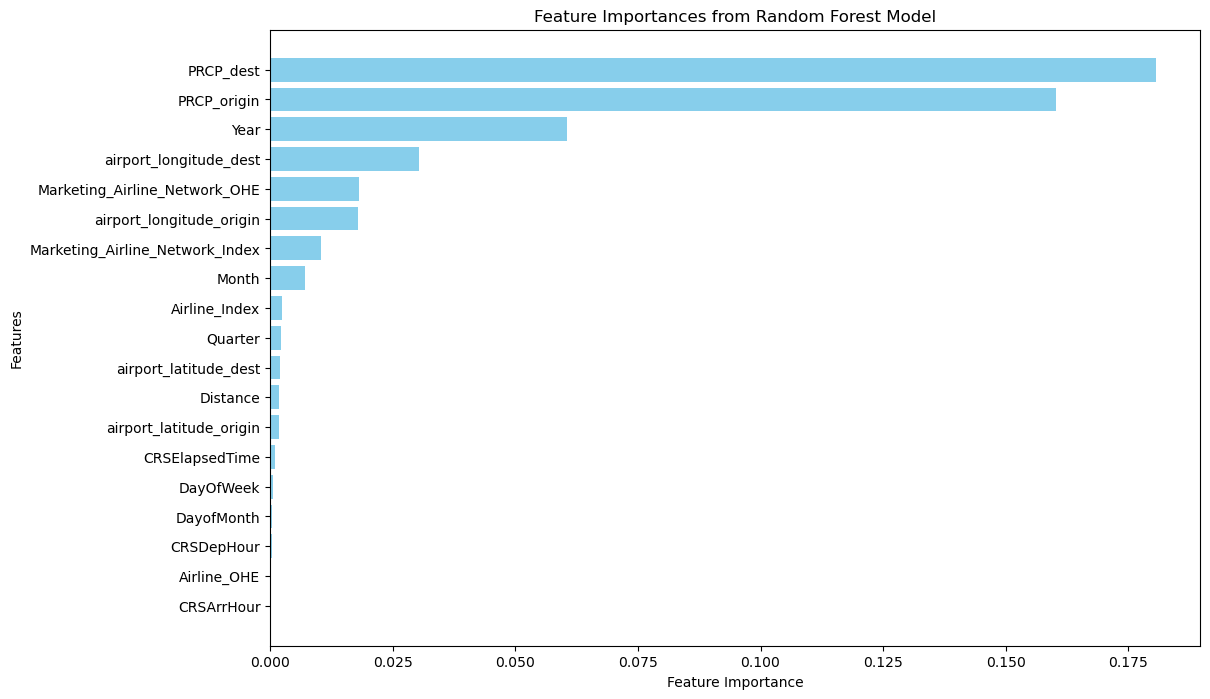

In [45]:
feature_importances = rf_model.featureImportances.toArray()

feature_importance_dict = {name: importance for name, importance in zip(features, feature_importances)}

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

features_1, importances = zip(*sorted_features)

plt.figure(figsize=(12, 8))
plt.barh(features_1, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## **2.2 Random Forest with Cross-Validation (Taking Too Long)**

In [47]:
# %%time

# # Select the features and target
# features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

# # Step 1: Combine features into a single vector
# assembler = VectorAssembler(inputCols=features, outputCol="features")
# df_prepared = assembler.transform(df_encoded)

# # Step 2: Split data into training and testing datasets
# train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)
# # Step 3: Initialize Random Forest Classifier
# rf = RandomForestClassifier(featuresCol="features", labelCol=target, seed=42)

# # Step 4: Set up the parameter grid for hyperparameter tuning
# paramGrid = (ParamGridBuilder()
#              .addGrid(rf.numTrees, [50, 100])
#              .addGrid(rf.maxDepth, [5, 10, 20])
#              .build())

# # Step 5: Initialize CrossValidator
# evaluator = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")

# crossval = CrossValidator(estimator=rf,
#                           evaluator=evaluator,
#                           estimatorParamMaps=paramGrid,
#                           numFolds=5,  # 5-fold cross-validation
#                           parallelism=2)  # Use 2 cores for parallelism

# # Step 6: Train the model with cross-validation
# cv_model = crossval.fit(train_df)

# # Step 7: Make predictions on the test dataset
# predictions = cv_model.transform(test_df)

# # Step 8: Initialize the evaluator for various metrics
# evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
# evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
# evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
# evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

# # Step 9: Calculate and print the metrics
# accuracy = evaluator_accuracyevaluate(predictions)
# precision = evaluator_precision.evaluate(predictions)
# recall = evaluator_recall.evaluate(predictions)
# f1_score = evaluator_f1.evaluate(predictions)

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1_score:.4f}")

# # Optional: Show some predictions
# predictions.select("DepDel15", "probability", "prediction").show(10)


## **2.3 GBT Model**

In [49]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/ArrDel15_lgbm_model_rohit"
gbt = GBTClassificationModel.load(model_path)

In [50]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

#gbt = GBTClassifier(featuresCol="features", labelCol=target, maxIter=100)

# gbt_model = gbt.fit(train_df)

predictions = gbt_model.transform(test_df)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8340
Precision: 0.7995
Recall: 0.8340
F1 Score: 0.7737
CPU times: user 111 ms, sys: 27.5 ms, total: 139 ms
Wall time: 3min 22s


In [51]:
df_metrics = predictions.select("ArrDel15", "prediction")

tp_condition = (col("ArrDel15") == 1) & (col("prediction") == 1)  # True Positive
tn_condition = (col("ArrDel15") == 0) & (col("prediction") == 0)  # True Negative
fp_condition = (col("ArrDel15") == 0) & (col("prediction") == 1)  # False Positive
fn_condition = (col("ArrDel15") == 1) & (col("prediction") == 0)  # False Negative

metrics = df_metrics.select(
    sum(when(tp_condition, 1).otherwise(0)).alias("TP"),
    sum(when(tn_condition, 1).otherwise(0)).alias("TN"),
    sum(when(fp_condition, 1).otherwise(0)).alias("FP"),
    sum(when(fn_condition, 1).otherwise(0)).alias("FN")
)

metrics.toPandas().stack()

0  TP      51907
   TN    3934632
   FP      33024
   FN     760341
dtype: int64

In [52]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/ArrDel15_lgbm_model_rohit"
#gbt_model.write().overwrite().save(model_path)

## **2.4 Logistic Regression**

In [53]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/ArrDel15_LR_model_rohit"
lr_model = LogisticRegressionModel.load(model_path)

In [54]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

# scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
# scaler_model = scaler.fit(df_prepared)
# df_scaled = scaler_model.transform(df_prepared)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol=target, regParam=0.1, maxIter=50)
# lr_model = lr.fit(train_df)
predictions = lr_model.transform(test_df)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8301
Precision: 0.6890
Recall: 0.8301
F1 Score: 0.7530
CPU times: user 93.1 ms, sys: 20.4 ms, total: 113 ms
Wall time: 2min 6s


In [55]:
df_metrics = predictions.select("ArrDel15", "prediction")

tp_condition = (col("ArrDel15") == 1) & (col("prediction") == 1)  # True Positive
tn_condition = (col("ArrDel15") == 0) & (col("prediction") == 0)  # True Negative
fp_condition = (col("ArrDel15") == 0) & (col("prediction") == 1)  # False Positive
fn_condition = (col("ArrDel15") == 1) & (col("prediction") == 0)  # False Negative

metrics = df_metrics.select(
    sum(when(tp_condition, 1).otherwise(0)).alias("TP"),
    sum(when(tn_condition, 1).otherwise(0)).alias("TN"),
    sum(when(fp_condition, 1).otherwise(0)).alias("FP"),
    sum(when(fn_condition, 1).otherwise(0)).alias("FN")
)

# Show the result
metrics.toPandas().stack()

0  TP          0
   TN    3967656
   FP          0
   FN     812248
dtype: int64

In [56]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/ArrDel15_LR_model_rohit"
#lr_model.write().overwrite().save(model_path)

## **2.5 Decision Tree**

In [57]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/ArrDel15_DT_model_rohit"
dt_model = DecisionTreeClassificationModel.load(model_path)

In [58]:
%%time

features = [x for x in df_encoded.columns if x not in [target, 'Airline', 'Marketing_Airline_Network']]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_prepared = assembler.transform(df_encoded)

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

# Set hyperparameters
dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol=target,
    maxDepth=10,               
    maxBins=32,                
    minInstancesPerNode=5,     
    minInfoGain=0.01,          
    impurity="gini",           
    seed=42                    
)

predictions = dt_model.transform(test_df)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8301
Precision: 0.6890
Recall: 0.8301
F1 Score: 0.7530
CPU times: user 93.5 ms, sys: 21.4 ms, total: 115 ms
Wall time: 2min 7s


In [59]:
df_metrics = predictions.select("ArrDel15", "prediction")

tp_condition = (col("ArrDel15") == 1) & (col("prediction") == 1)  # True Positive
tn_condition = (col("ArrDel15") == 0) & (col("prediction") == 0)  # True Negative
fp_condition = (col("ArrDel15") == 0) & (col("prediction") == 1)  # False Positive
fn_condition = (col("ArrDel15") == 1) & (col("prediction") == 0)  # False Negative

metrics = df_metrics.select(
    sum(when(tp_condition, 1).otherwise(0)).alias("TP"),
    sum(when(tn_condition, 1).otherwise(0)).alias("TN"),
    sum(when(fp_condition, 1).otherwise(0)).alias("FP"),
    sum(when(fn_condition, 1).otherwise(0)).alias("FN")
)

# Show the result
metrics.toPandas().stack()

0  TP          0
   TN    3967656
   FP          0
   FN     812248
dtype: int64

In [60]:
model_path = "gs://msca-bdp-student-gcs/Group11/Classification/ArrDel15_DT_model_rohit"
#dt_model.write().overwrite().save(model_path)

# **3. Regression Models - To predict and quantify delay in departure** 

In [61]:
gcs_path = "gs://msca-bdp-student-gcs/Group11/flight_weather_joined_2018_2021_v2.parquet"
df = spark.read.parquet(gcs_path)

In [63]:
from pyspark.sql.functions import year, dayofyear, lit
df = df.withColumn("day_encode", dayofyear(df["FlightDate"]) / lit(365))

In [64]:
df = df.na.drop(subset=["DepDelayMinutes", "Year", "day_encode","airport_latitude_origin", "airport_longitude_origin","PRCP_origin", "Airline"])


In [65]:
train_data = df.filter((col("Year") < 2021) | ((col("Year") == 2021) & (col("day_encode") <= 0.5)))
test_data = df.filter((col("Year") == 2021) & (col("day_encode") > 0.5))
print(train_data.count())
print(test_data.count())

20793839


3419875


In [66]:
airline_indexer = StringIndexer(inputCol="Airline", outputCol="Airline_Encoded", handleInvalid="skip")
train_data = airline_indexer.fit(train_data).transform(train_data)
test_data = airline_indexer.fit(test_data).transform(test_data)

In [67]:
feature_cols = ["Year", "day_encode", "airport_latitude_origin", "airport_longitude_origin", "PRCP_origin", "Airline_Encoded"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data).select("features", "DepDelayMinutes")
test_data = assembler.transform(test_data).select("features", "DepDelayMinutes")

## **3.1 - GBT Regressor Model**

In [79]:
from pyspark.ml.regression import GBTRegressionModel,RandomForestRegressionModel
from pyspark.ml.tuning import CrossValidatorModel

In [72]:

model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_delayminutes_gbt"
gbt_regr=GBTRegressionModel.load(model_path)

In [75]:
from pyspark.ml.evaluation import RegressionEvaluator



'''
gbt = GBTRegressor(featuresCol="features", labelCol="DepDelayMinutes")

# Parameter grid for maxIter and stepSize
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [25, 50, 100]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="DepDelayMinutes", metricName="rmse")

# Define the cross-validator
crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2  # Adjust based on your cluster's available cores
)

# Fit the cross-validated model
cv_model = crossval.fit(train_data)

# Retrieve the best model and parameters
best_model = cv_model.bestModel
best_maxIter = best_model._java_obj.getMaxIter()
print(f"Best maxIter: {best_maxIter}")
'''

gbt_predictions = gbt_regr.transform(test_data)
evaluator = RegressionEvaluator(labelCol="DepDelayMinutes", predictionCol="prediction", metricName="rmse")
gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"GBT Regression RMSE: {gbt_rmse}")

GBT Regression RMSE: 50.09323477890849


'\ngbt = GBTRegressor(featuresCol="features", labelCol="DepDelayMinutes")\n\n# Parameter grid for maxIter and stepSize\nparamGrid = ParamGridBuilder()     .addGrid(gbt.maxIter, [25, 50, 100])     .addGrid(gbt.stepSize, [0.05, 0.1])     .build()\n\n# Define the evaluator\nevaluator = RegressionEvaluator(labelCol="DepDelayMinutes", metricName="rmse")\n\n# Define the cross-validator\ncrossval = CrossValidator(\n    estimator=gbt,\n    estimatorParamMaps=paramGrid,\n    evaluator=evaluator,\n    numFolds=5,\n    parallelism=2  # Adjust based on your cluster\'s available cores\n)\n\n# Fit the cross-validated model\ncv_model = crossval.fit(train_data)\n\n# Retrieve the best model and parameters\nbest_model = cv_model.bestModel\nbest_maxIter = best_model._java_obj.getMaxIter()\nprint(f"Best maxIter: {best_maxIter}")\n'

## **3.2 - Random Forest Model**

In [80]:
model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_delayminutes_rf"
rf_regr=CrossValidatorModel.load(model_path)

'''rf = RandomForestRegressor(featuresCol="features", labelCol="DepDelayMinutes", predictionCol="prediction")

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

rf_cv = CrossValidator(estimator=rf,
                        estimatorParamMaps=rf_param_grid,
                        evaluator=RegressionEvaluator(labelCol="DepDelayMinutes", metricName="rmse"),
                        numFolds=5,
                        parallelism=8)

rf_model = rf_cv.fit(train_data)
model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_delayminutes_rf"
rf_model.write().overwrite().save(model_path)'''

'rf = RandomForestRegressor(featuresCol="features", labelCol="DepDelayMinutes", predictionCol="prediction")\n\nrf_param_grid = ParamGridBuilder()     .addGrid(rf.numTrees, [50, 100])     .addGrid(rf.maxDepth, [5, 10])     .build()\n\nrf_cv = CrossValidator(estimator=rf,\n                        estimatorParamMaps=rf_param_grid,\n                        evaluator=RegressionEvaluator(labelCol="DepDelayMinutes", metricName="rmse"),\n                        numFolds=5,\n                        parallelism=8)\n\nrf_model = rf_cv.fit(train_data)\nmodel_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_delayminutes_rf"\nrf_model.write().overwrite().save(model_path)'

In [82]:
rf_predictions = rf_regr.bestModel.transform(test_data)
rf_rmse = RegressionEvaluator(labelCol="DepDelayMinutes", predictionCol="prediction", metricName="rmse").evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest RMSE: 49.05921998406257


# **4. Regression Models - To predict and quantify delay in arrivals** 

In [83]:
gcs_path = "gs://msca-bdp-student-gcs/Group11/flight_weather_joined_2018_2021_v2.parquet"
df = spark.read.parquet(gcs_path)

In [84]:
df = df.withColumn("day_encode", dayofyear(df["FlightDate"]) / lit(365))

In [85]:
df = df.na.drop(subset=["ArrDelayMinutes", "Year", "day_encode","airport_latitude_dest", "airport_longitude_dest","PRCP_dest", "Airline"])

In [86]:
df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns]).show(vertical=True,truncate=False)

-RECORD 0------------------------------------------
 FlightDate                              | 0       
 Airline                                 | 0       
 Origin                                  | 0       
 Dest                                    | 0       
 Cancelled                               | 0       
 Diverted                                | 0       
 CRSDepTime                              | 0       
 DepTime                                 | 1       
 DepDelayMinutes                         | 1073    
 DepDelay                                | 1073    
 ArrTime                                 | 2       
 ArrDelayMinutes                         | 0       
 AirTime                                 | 5862    
 CRSElapsedTime                          | 1       
 ActualElapsedTime                       | 2       
 Distance                                | 0       
 Year                                    | 0       
 Quarter                                 | 0       
 Month      

In [87]:
train_data = df.filter((col("Year") < 2021) | ((col("Year") == 2021) & (col("day_encode") <= 0.5)))
test_data = df.filter((col("Year") == 2021) & (col("day_encode") > 0.5))

In [88]:
print(train_data.count())
print(test_data.count())

20734433


3409593


In [89]:
airline_indexer = StringIndexer(inputCol="Airline", outputCol="Airline_Encoded", handleInvalid="skip")
train_data = airline_indexer.fit(train_data).transform(train_data)
test_data = airline_indexer.fit(test_data).transform(test_data)

In [90]:
feature_cols = ["Year", "day_encode", "airport_latitude_dest", "airport_longitude_dest", "PRCP_dest", "Airline_Encoded"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [91]:
train_data = assembler.transform(train_data).select("features", "ArrDelayMinutes")
test_data = assembler.transform(test_data).select("features", "ArrDelayMinutes")

In [92]:
train_data.write.mode("overwrite").parquet(f"gs://msca-bdp-student-gcs/Group11/reethesh_train_arr")
train_data.write.mode("overwrite").parquet(f"gs://msca-bdp-student-gcs/Group11/reethesh_test_arr")

## **4.1 GBT Regressor Model**

In [93]:

model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_arrminutes_gbt"
gbt_regr=GBTRegressionModel.load(model_path)

In [94]:
'''
gbt = GBTRegressor(featuresCol="features", labelCol="ArrDelayMinutes")

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [25, 50, 100]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .build()

evaluator = RegressionEvaluator(labelCol="ArrDelayMinutes", metricName="rmse")

crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=8  # Adjust based on your cluster's available cores
)

cv_model = crossval.fit(train_data)

best_model = cv_model.bestModel
best_maxIter = best_model._java_obj.getMaxIter()
print(f"Best maxIter: {best_maxIter}")
'''
model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_arrminutes_gbt"
#best_model.write().overwrite().save(model_path)

gbt_predictions = gbt_regr.transform(test_data)
evaluator = RegressionEvaluator(labelCol="ArrDelayMinutes", predictionCol="prediction", metricName="rmse")
gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"GBT Regression RMSE: {gbt_rmse}")

GBT Regression RMSE: 49.26762584440581


In [95]:
model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_arrminutes_gbt"
#best_model.write().overwrite().save(model_path)

## **4.2 Random Forest Model**

In [99]:
model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_arrminutes_rf"
rf_regr=CrossValidatorModel.load(model_path)

In [100]:
'''rf = RandomForestRegressor(featuresCol="features", labelCol="ArrDelayMinutes", predictionCol="prediction")

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

rf_cv = CrossValidator(estimator=rf,
                        estimatorParamMaps=rf_param_grid,
                        evaluator=RegressionEvaluator(labelCol="ArrDelayMinutes", metricName="rmse"),
                        numFolds=5,
                        parallelism=8)

rf_model = rf_cv.fit(train_data)
model_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_arrminutes_rf"
rf_model.write().overwrite().save(model_path)'''

'rf = RandomForestRegressor(featuresCol="features", labelCol="ArrDelayMinutes", predictionCol="prediction")\n\nrf_param_grid = ParamGridBuilder()     .addGrid(rf.numTrees, [50, 100])     .addGrid(rf.maxDepth, [5, 10])     .build()\n\nrf_cv = CrossValidator(estimator=rf,\n                        estimatorParamMaps=rf_param_grid,\n                        evaluator=RegressionEvaluator(labelCol="ArrDelayMinutes", metricName="rmse"),\n                        numFolds=5,\n                        parallelism=8)\n\nrf_model = rf_cv.fit(train_data)\nmodel_path = f"gs://msca-bdp-student-gcs/Group11/reethesh_arrminutes_rf"\nrf_model.write().overwrite().save(model_path)'

In [101]:
rf_predictions = rf_regr.transform(test_data)
rf_rmse = RegressionEvaluator(labelCol="ArrDelayMinutes", predictionCol="prediction", metricName="rmse").evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest RMSE: 48.571967584181124
